In [ ]:
def fd_hu_moments(image):
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    feature = cv2.HuMoments(cv2.moments(image)).flatten()
    return feature

In [ ]:
def fd_haralick(image):
    # convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # compute the haralick texture feature vector
    haralick = mahotas.features.haralick(image).mean(axis=0)
    # return the result
    return haralick


In [ ]:
!pip install mahotas

In [ ]:
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
import mahotas
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:


#--------------------
# tunable-parameters
#--------------------
images_per_class = 1250
fixed_size       = tuple((290,350))
bins             = 8

In [ ]:
train_path="/content/drive/My Drive/dataset"


# get the training labels
train_labels = os.listdir(train_path)
print(train_labels)
# sort the training labels
train_labels.sort()
print(train_labels)

# empty lists to hold feature vectors and labels
global_features = []
labels          = []

['right', 'down', 'left', 'up']
['down', 'left', 'right', 'up']


In [ ]:
def extract_feature(path,fixed_size):
  image=cv2.imread(path)
  image = cv2.resize(image, fixed_size)
  frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  ret,thresh = cv2.threshold(frame,125,255,cv2.THRESH_TOZERO)
  fv_hu_moments = fd_hu_moments(thresh)
  fv_haralick   = fd_haralick(thresh)
  feature=np.hstack([fv_haralick, fv_hu_moments])
  # print(feature)
  normalize=[i/255 for i in feature]
  return normalize

In [ ]:
a=extract_feature('/content/img-000213.png',fixed_size)
print(a)
print(np.array(a).shape)
# scalers            = MinMaxScaler(feature_range=(0, 1))
# rescaled_features1 = scalers.fit_transform(a.reshape(1,-1))
# print(rescaled_features1)

[0.00187558076089084, 0.5664140138570628, 0.0038934961172749183, 39.55281576360813, 0.003232954802601603, 0.5115920264224246, 157.64484904057545, 0.012400239103997356, 0.01535388674757005, 9.274983171893841e-06, 0.0060391587573118055, -0.002412157570429665, 0.0038597264445797224, 6.235144579540038e-06, 6.992106522152394e-09, 1.8756436427742647e-12, 1.850429341201104e-12, 8.662732797201118e-22, 2.4650648221228738e-15, -1.4945556540370414e-22]
(20,)


In [ ]:

# loop over the training data sub-folders
for training_name in train_labels:
    # join the training data path and each species training folder
    dir = os.path.join(train_path, training_name)

    # get the current training label
    current_label = training_name

    # loop over the images in each sub-folder
    x=os.listdir(dir)
    x=np.array(x)
    x.reshape(1,-1)
    for i in x:
        file=os.path.join(dir,i)
        print(file)
        global_feature=extract_feature(file,fixed_size)
        labels.append(current_label)
        global_features.append(global_feature)

    print("[STATUS] processed folder: {}".format(current_label))

print("[STATUS] completed Global Feature Extraction...")


In [ ]:
h5_data          = '/content/drive/My Drive/output/data.h5'
h5_labels        = '/content/drive/My Drive/output/labels.h5'
# get the overall feature vector size
print("[STATUS] feature vector size {}".format(np.array(global_features).shape))

# get the overall training label size
print("[STATUS] training Labels {}".format(np.array(labels).shape))

# encode the target labels
targetNames = np.unique(labels)
le          = LabelEncoder()
target      = le.fit_transform(labels)
print("[STATUS] training labels encoded...")



print("[STATUS] target labels: {}".format(target))
print("[STATUS] target labels shape: {}".format(target.shape))

# save the feature vector using HDF5
h5f_data = h5py.File(h5_data, 'w')
h5f_data.create_dataset('dataset_1', data=np.array(global_features))

h5f_label = h5py.File(h5_labels, 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()

print("[STATUS] end of training..")

[STATUS] feature vector size (5000, 20)
[STATUS] training Labels (5000,)
[STATUS] training labels encoded...
[STATUS] target labels: [0 0 0 ... 3 3 3]
[STATUS] target labels shape: (5000,)
[STATUS] end of training..


In [ ]:
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (5000, 20)
[STATUS] labels shape: (5000,)
[STATUS] training started...


In [ ]:
# global_features=np.array(global_features).reshape(5000,20)

(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=0.2,
                                                                                          random_state=42)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (4000, 20)
Test data   : (1000, 20)
Train labels: (4000,)
Test labels : (1000,)


LR: 0.825250 (0.028360)
LDA: 1.000000 (0.000000)
KNN: 0.932500 (0.015732)
CART: 0.999750 (0.000750)
RF: 0.999750 (0.000750)
NB: 0.887250 (0.019152)
SVM: 0.659500 (0.029428)


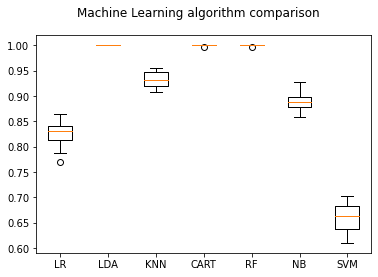

In [ ]:

scoring    = "accuracy"
seed=9
num_trees=100
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model,trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_fscore_support as score

print("\n=====================LogisticRegression======================\n")
model1=LogisticRegression()
model1.fit(trainDataGlobal,trainLabelsGlobal)
y_pred1 = model1.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred1))

cnf_matrix1 = confusion_matrix(testLabelsGlobal, y_pred1)
print('Confusion matrix:')
print(cnf_matrix1)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred1)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

#####
print("\n=====================LinearDiscriminantAnalysis======================\n")
model2=LinearDiscriminantAnalysis()
model2.fit(trainDataGlobal,trainLabelsGlobal)
y_pred2 = model2.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred2))

cnf_matrix2 = confusion_matrix(testLabelsGlobal, y_pred2)
print('Confusion matrix:')
print(cnf_matrix2)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred2)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

print("\n=====================KNeighborsClassifier======================\n")

####
model3=KNeighborsClassifier(n_neighbors=5)
model3.fit(trainDataGlobal,trainLabelsGlobal)
y_pred3 = model3.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred3))

cnf_matrix3 = confusion_matrix(testLabelsGlobal, y_pred3)
print('Confusion matrix:')
print(cnf_matrix3)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred3)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


####
print("\n=====================DecisionTreeClassifier======================\n")

model4= DecisionTreeClassifier()
model4.fit(trainDataGlobal,trainLabelsGlobal)
y_pred4 = model4.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred4))

cnf_matrix4 = confusion_matrix(testLabelsGlobal, y_pred4)
print('Confusion matrix:')
print(cnf_matrix4)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred4)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


###
print("\n=====================RandomForestClassifier======================\n")

model5=RandomForestClassifier(n_estimators=100,random_state=0)
model5.fit(trainDataGlobal,trainLabelsGlobal)
y_pred5 = model5.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred5))

cnf_matrix5 = confusion_matrix(testLabelsGlobal, y_pred5)
print('Confusion matrix:')
print(cnf_matrix5)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred5)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


####
print("\n=====================GaussianNB======================\n")

model6=GaussianNB()
model6.fit(trainDataGlobal,trainLabelsGlobal)
y_pred6 = model6.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred6))

cnf_matrix6 = confusion_matrix(testLabelsGlobal, y_pred6)
print('Confusion matrix:')
print(cnf_matrix6)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred6)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))



###
print("\n=====================SVC======================\n")
(5000,20)

model7=SVC(random_state=0)
model7.fit(trainDataGlobal,trainLabelsGlobal)
y_pred7 = model7.predict(testDataGlobal)
print('accuracy = ',accuracy_score(testLabelsGlobal, y_pred7))

cnf_matrix7 = confusion_matrix(testLabelsGlobal, y_pred7)
print('Confusion matrix:')
print(cnf_matrix7)
# y_score = model1.decision_function(x_val)
precision, recall, fscore, support = score(testLabelsGlobal, y_pred7)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))



=====================LogisticRegression======================

accuracy =  0.828
Confusion matrix:
[[220   7   0  43]
 [ 68 151   0  11]
 [  0   0 255   0]
 [ 17  24   2 202]]
precision: [0.72131148 0.82967033 0.9922179  0.7890625 ]
recall: [0.81481481 0.65652174 1.         0.8244898 ]
fscore: [0.76521739 0.73300971 0.99609375 0.80638723]
support: [270 230 255 245]

=====================LinearDiscriminantAnalysis======================

accuracy =  1.0
Confusion matrix:
[[270   0   0   0]
 [  0 230   0   0]
 [  0   0 255   0]
 [  0   0   0 245]]
precision: [1. 1. 1. 1.]
recall: [1. 1. 1. 1.]
fscore: [1. 1. 1. 1.]
support: [270 230 255 245]

=====================KNeighborsClassifier======================

accuracy =  0.952
Confusion matrix:
[[245  21   0   4]
 [  1 220   0   9]
 [  0   0 255   0]
 [  7   6   0 232]]
precision: [0.96837945 0.89068826 1.         0.94693878]
recall: [0.90740741 0.95652174 1.         0.94693878]
fscore: [0.93690249 0.92243187 1.         0.94693878]
support:

In [ ]:
y_pred = model3.predict(testDataGlobal)
print(y_pred)
print("Result: ", (y_pred == testLabelsGlobal).tolist().count(True)/1000)

[1 2 2 0 0 0 0 1 1 1 1 0 0 0 2 2 0 2 1 0 0 2 0 0 3 0 3 0 0 0 1 1 3 3 1 2 2
 3 3 1 2 3 0 0 0 3 3 3 2 2 3 3 1 2 0 2 0 0 1 2 1 3 3 3 0 2 2 1 2 3 1 1 0 0
 0 1 0 2 2 3 2 2 3 1 2 3 0 0 3 3 3 0 0 3 0 3 2 2 0 0 1 1 1 3 3 0 0 1 3 1 1
 0 3 0 1 2 1 1 0 1 1 0 3 0 1 3 1 3 2 2 3 2 1 1 3 3 3 2 0 0 2 3 3 3 3 2 2 2
 2 2 1 3 3 3 1 0 2 2 2 0 1 2 0 0 0 2 0 1 2 1 2 1 2 2 0 2 3 2 0 1 3 2 1 0 2
 2 2 2 0 1 0 3 3 3 1 0 0 2 3 3 3 0 2 3 2 1 1 2 3 0 2 0 2 1 3 1 0 0 3 0 1 0
 3 2 1 2 2 2 0 1 0 3 3 3 0 2 2 0 2 3 0 0 3 3 1 1 1 1 1 3 0 3 1 1 1 0 2 1 0
 0 1 1 1 3 1 1 1 2 2 0 0 1 3 0 1 2 1 2 2 3 3 3 0 0 1 3 0 2 1 0 0 2 1 1 2 0
 1 1 3 0 0 0 2 1 2 3 3 2 0 1 2 2 1 3 1 0 1 2 3 2 0 3 1 2 0 0 1 1 3 3 3 0 3
 0 3 0 0 0 1 0 3 3 1 1 2 2 3 2 1 1 2 3 1 0 3 0 2 0 0 1 1 0 2 1 0 2 0 0 0 3
 3 2 1 1 1 3 2 1 0 3 3 3 2 0 1 1 3 0 0 1 1 3 2 0 0 2 1 1 3 2 0 3 0 2 2 1 1
 0 0 2 0 2 2 1 0 3 1 3 2 2 2 2 1 0 3 3 0 1 3 0 0 3 1 2 1 2 1 3 0 2 2 1 2 1
 1 1 1 3 0 0 2 2 3 1 3 1 1 2 2 0 1 0 1 2 2 2 2 3 3 3 2 2 0 2 2 2 2 1 0 0 3
 3 1 2 3 0 0 2 0 0 0 3 0 

In [ ]:
from joblib import dump, load
dump(model4, 'weight.joblib') 
clf = load('weight.joblib') 

In [ ]:
import pickle 
  

Pkl_Filename = "Pickle_RL_Model.pkl"  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model4, file)

In [ ]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
file='/content/img-000213.png'
features=[]
feature=extract_feature(file,fixed_size)
features.append(feature)
y=model4.predict(features)
print(y)


[3]


In [ ]:

file='/content/img-000936.png'
features=[]
feature=extract_feature(file,fixed_size)
features.append(feature)
y=model4.predict(features)
print(y)


[0]


In [ ]:
file='/content/img-000721.png'
features=[]
feature=extract_feature(file,fixed_size)
features.append(feature)
y=model4.predict(features)
print(y)

[1]


In [ ]:

file='/content/img-002756.png'
features=[]
feature=extract_feature(file,fixed_size)
features.append(feature)
y=model4.predict(features)
print(y)

[2]


In [ ]:

file='/content/img-000232.png'
features=[]
feature=extract_feature(file,fixed_size)
features.append(feature)
y=model4.predict(features)
print(y)

[3]
